To perform registration with `DiffDRR`, we do the following:

1. Obtain a target X-ray (this is the image whose pose parameters we wish to recovery)
2. Initialize a moving DRR module from a random camera pose
3. Measure the loss between the target X-ray and the moving DRR (we use normalized negative cross-correlation)
4. Backpropogate this loss the parameters of the moving DRR and render from the new parameters
5. Repeat Steps 3-4 until the loss has converged

## 1. Generate a target X-ray

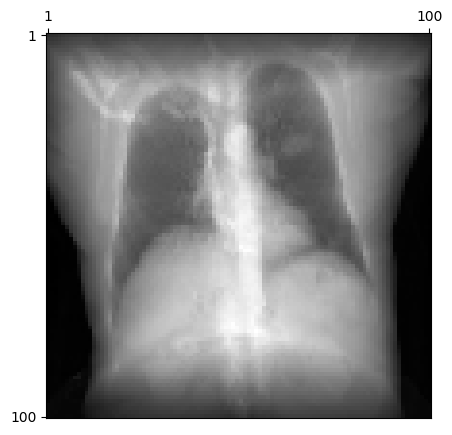

cuda


In [4]:
#| code-fold: true
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR, Registration
from diffdrr.metrics import NormalizedCrossCorrelation2d
from diffdrr.visualization import plot_drr

np.random.seed(39)

# Make the ground truth X-ray
SDR = 300.0
HEIGHT = 100
DELX = 8.0

volume, spacing = load_example_ct()
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
true_params = {
    "sdr": SDR,
    "alpha": torch.pi,
    "beta": 0,
    "gamma": torch.pi / 2,
    "bx": bx,
    "by": by,
    "bz": bz,
}
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
rotations = torch.tensor(
    [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
    ]
).to(device)
translations = torch.tensor(
    [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
    ]
).to(device)
ground_truth = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
)

plot_drr(ground_truth)
plt.show()
print(device)

## 2. Initialize a moving DRR from a random pose

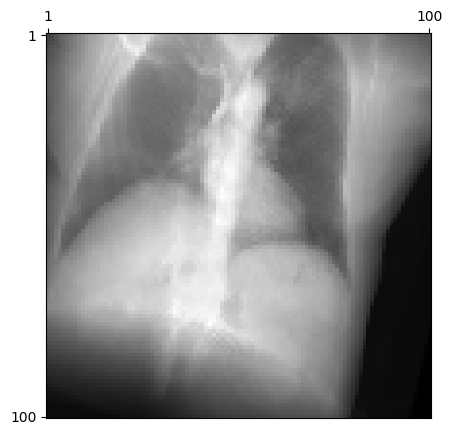

In [6]:
#| code-fold: true
# Make a random DRR
def get_initial_parameters(true_params):
    alpha = true_params["alpha"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    beta = true_params["beta"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 31.0)
    by = true_params["by"] + np.random.uniform(-30.0, 31.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 31.0)
    rotation = torch.tensor([[alpha, beta, gamma]]).to(device)
    translation = torch.tensor([[bx, by, bz]]).to(device)
    return rotation, translation


rotations, translations = get_initial_parameters(true_params)
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZYX",
    )
plot_drr(est)
plt.show()

## 3. Measure the loss between the target X-ray and moving DRR

We start by measuring the initial loss between the two images.

In [7]:
criterion = NormalizedCrossCorrelation2d()
criterion(ground_truth, est).item()

0.6877472400665283

If the negative normalized cross-correlation is greater than 0.999, we say the target and moving DRR have converged.

## 4. Backpropogate the loss to the moving DRR parameters

We also use this example to show how different optimizers affect the outcome of registration.
The parameters we tweak are

- `lr_rotations`: learning rate for rotation parameters
- `lr_translations`: learning rate for translation parameters
- `momentum`: momentum for stochastic gradient descent
- `dampening`: dampening for stochastic gradient descent

In [8]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=5.3e-2,
    lr_translations=7.5e1,
    momentum=0,
    dampening=0,
    n_itrs=250,
    optimizer="sgd",  # 'sgd' or `adam`
):
    criterion = NormalizedCrossCorrelation2d()
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
    else:
        optimizer = torch.optim.Adam(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            maximize=True,
        )

    params = []
    losses = []
    for itr in tqdm(range(n_itrs), ncols=50):
        # Save the current set of parameters
        alpha, beta, gamma = reg.get_rotation().squeeze().tolist()
        bx, by, bz = reg.get_translation().squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        loss = criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())

        if loss > 0.999:
            tqdm.write(f"Converged in {itr} iterations")
            break

    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

## Run the optimization algorithm

In [9]:
# Base SGD
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZYX",
)
params_base = optimize(reg, ground_truth)
del drr

# SGD + momentum
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZYX",
)
params_momentum = optimize(reg, ground_truth, momentum=0.9)
del drr

# SGD + momentum + dampening
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZYX",
)
params_momentum_dampen = optimize(reg, ground_truth, momentum=0.9, dampening=0.1)
del drr

# Adam
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZYX",
)
params_adam = optimize(reg, ground_truth, 1e-1, 1e1, optimizer="adam")
del drr

 58%|██████▎    | 144/250 [00:01<00:01, 93.20it/s]


Converged in 144 iterations


 24%|██▊         | 59/250 [00:00<00:02, 94.88it/s]


Converged in 59 iterations


 23%|██▋         | 57/250 [00:00<00:02, 94.82it/s]


Converged in 57 iterations


 17%|██          | 42/250 [00:00<00:02, 86.99it/s]

Converged in 42 iterations


## Visualize the parameter updates

Note that differences that between different optimization algorithms can be seen in the motion in the DRRs!

In [10]:
#| code-fold: true
from base64 import b64encode

from IPython.display import HTML, display

from diffdrr.visualization import animate


def animate_in_browser(df, max_length):
    n = max_length - len(df)
    df = pd.concat([df, df.iloc[[-1] * n]])

    out = animate(
        "<bytes>",
        df,
        drr,
        ground_truth=ground_truth,
        verbose=True,
        device=device,
        extension=".webp",
        duration=30,
        parameterization="euler_angles",
        convention="ZYX",
    )
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))


drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)

In [11]:
animate_in_browser(params_base, len(params_base))

Precomputing DRRs: 100%|█████████████████| 145/145 [00:12<00:00, 11.79it/s]


In [ ]:
animate_in_browser(params_momentum, len(params_base))

Precomputing DRRs: 100%|█████████████████| 139/139 [00:24<00:00,  5.66it/s]


In [ ]:
animate_in_browser(params_momentum_dampen, len(params_base))

Precomputing DRRs: 100%|█████████████████| 139/139 [00:24<00:00,  5.60it/s]


In [12]:
animate_in_browser(params_adam, len(params_base))

Precomputing DRRs: 100%|█████████████████| 145/145 [00:12<00:00, 11.76it/s]
